In [3]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import fsolve
import datetime

# 1. 讀取全市場股價資料

In [4]:
AllStockData = pd.read_csv('stockdata.csv', encoding='utf-8')

In [5]:
# 以'1704榮化'為例
stocklist = [1704]

In [6]:
AllStockData.head()

,Unnamed: 0,code,name,industry,date,open,high,low,close,trade_volume,trade_value,return,outstanding_share,market_value,market_type
0,1,1101,台泥,1,20070102,16.70,16.78,16.53,16.75,4092,121125.0,1.0187,3141610.0,93462.0,TSE
1,2,1101,台泥,1,20070103,16.75,16.81,16.58,16.58,4839,143703.0,-1.0084,3141610.0,92520.0,TSE
2,3,1101,台泥,1,20070104,16.41,16.58,16.41,16.53,2318,67831.0,-0.3396,3141610.0,92206.0,TSE
3,4,1101,台泥,1,20070105,16.53,16.55,16.30,16.36,7197,209439.0,-1.0221,3141610.0,91263.0,TSE
4,5,1101,台泥,1,20070108,16.05,16.39,16.05,16.33,6579,190433.0,-0.1721,3141610.0,91106.0,TSE


In [7]:
StockDataRaw = AllStockData[AllStockData['code']==stocklist[0]][['code','date','close']]

In [8]:
StockDataRaw.head()

,code,date,close
436724,1704,20070102,17.30
436725,1704,20070103,17.02
436726,1704,20070104,16.60
436727,1704,20070105,16.81
436728,1704,20070108,16.60


# 2. 設置策略參數

In [9]:
# ===============================initial parameters===========================
Mm = 10000000
cash_ratio = 0.2
M = Mm*(1-cash_ratio)
Time = 3
day_in_year = 252
r = 0.013
h = 1.1
vol_day = 20
in_sample_last_year = 2012
tc_buy = 0.001425
tc_sell = 0.004425

In [10]:
StockData = StockDataRaw
StockData['lagClose'] = StockData['close'].shift(1)
StockData['return'] = np.log(StockData['close']/StockData['lagClose'])
StockData['vol'] = math.sqrt(252)*StockData['return'].rolling(vol_day).std()

In [11]:
StockData.head()

,code,date,close,lagClose,return,vol
436724,1704,20070102,17.30,NaN,NaN,NaN
436725,1704,20070103,17.02,17.30,-0.016317,NaN
436726,1704,20070104,16.60,17.02,-0.024986,NaN
436727,1704,20070105,16.81,16.60,0.012571,NaN
436728,1704,20070108,16.60,16.81,-0.012571,NaN


In [12]:
# 以2013年為界線分割樣本
in_sample_stock_data = StockData[StockData['date'] <= (in_sample_last_year*10000+1231)]

In [13]:
in_sample_stock_data.tail()

,code,date,close,lagClose,return,vol
438214,1704,20121224,29.78,28.98,0.027231,0.226840
438215,1704,20121225,30.12,29.78,0.011352,0.224829
438216,1704,20121226,30.29,30.12,0.005628,0.224821
438217,1704,20121227,30.37,30.29,0.002638,0.221292
438218,1704,20121228,30.42,30.37,0.001645,0.219939


In [14]:
out_stock_data = StockData[StockData['date'] > (in_sample_last_year*10000+1231)]

In [16]:
# 取30百分位的價格當作進入點
in_time_sp = in_sample_stock_data['close'].quantile(0.3)

In [17]:
# 在樣本外資料找尋進入點
in_position = np.amin(np.where(out_stock_data['close'] <= in_time_sp))

In [18]:
# 決定起始股價及波動度
out_stock_data1 = out_stock_data[in_position:]
out_stock_data1 = out_stock_data1[0:(Time*day_in_year)]
out_stock_data1.index = range(len(out_stock_data1))
S = float(out_stock_data1['close'][0:1])
vol=float(out_stock_data1['vol'][0:1])

In [19]:
def myFunction(x) :
    y = [0,0]
    m = x[0]
    K = x[1]
    d1 = (np.log(S/K)+(r+0.5*vol**2)*Time)/(vol*np.sqrt(Time))
    d2 = d1-vol*np.sqrt(Time)
    y[0] = ( M*(1+h)/K-m )
    y[1] = (M-m*(S*norm.cdf(-d1)+K*np.exp(-r*Time)*norm.cdf(d2)))
    return y
xStart = np.array([(M*(1+h)/(S * 1.1)), (S * 1.1)])
ans = fsolve(myFunction, xStart)

print (ans)

[  4.72515136e+05   3.55544166e+01]


In [20]:
# 解出最適持有張數m及履約價K
m = ans[0]
K = ans[1]

In [21]:
out_stock_data1['Tt'] = np.arange(Time, 0, step = -1/(day_in_year)).tolist()

In [22]:
out_stock_data1.head()

,code,date,close,lagClose,return,vol,Tt
0,1704,20140804,18.65,20.03,-0.071385,0.395150,3.000000
1,1704,20140805,17.36,18.65,-0.071677,0.451602,2.996032
2,1704,20140806,16.15,17.36,-0.072249,0.493685,2.992063
3,1704,20140807,15.03,16.15,-0.071872,0.532442,2.988095
4,1704,20140808,14.00,15.03,-0.070991,0.560035,2.984127


In [28]:
# 經由蛛網策略推演出的數學公式決定每日買賣張數
out_stock_data1['d1'] = ((np.log(out_stock_data1['close']/K)+(r+0.5*out_stock_data1['vol']**2)*out_stock_data1['Tt'])/(out_stock_data1['vol']*out_stock_data1['Tt'].apply(np.sqrt)))
out_stock_data1['stock_position'] = round(m*((-out_stock_data1['d1']).apply(norm.cdf))/1000)
out_stock_data1['lag_stock_Position'] = out_stock_data1['stock_position'].shift(1)
out_stock_data1['delta_Stock_Position'] = out_stock_data1['stock_position'] - out_stock_data1['lag_stock_Position']
out_stock_data1.head()

,code,date,close,lagClose,return,vol,Tt,d1,stock_position,lag_stock_Position,delta_Stock_Position
0,1704,20140804,18.65,20.03,-0.071385,0.395150,3.000000,-0.543530,334.0,NaN,NaN
1,1704,20140805,17.36,18.65,-0.071677,0.451602,2.996032,-0.476455,323.0,334.0,-11.0
2,1704,20140806,16.15,17.36,-0.072249,0.493685,2.992063,-0.451578,319.0,323.0,-4.0
3,1704,20140807,15.03,16.15,-0.071872,0.532442,2.988095,-0.433098,315.0,319.0,-4.0
4,1704,20140808,14.00,15.03,-0.070991,0.560035,2.984127,-0.439557,317.0,315.0,2.0


In [30]:
# 用淨值來觀察每日獲利趨勢
out_stock_data1['TC'] = np.nan
out_stock_data1['Cash'] = np.nan
out_stock_data1['Asset_value'] = np.nan
out_stock_data1['Fund_Value'] = np.nan
out_stock_data1['Net_Profit_Loss'] = np.nan
out_stock_data1['Cum_Profit_Loss'] = np.nan
out_stock_data1.head()

,code,date,close,lagClose,return,vol,Tt,d1,stock_position,lag_stock_Position,delta_Stock_Position,TC,Cash,Asset_value,Fund_Value,Net_Profit_Loss,Cum_Profit_Loss
0,1704,20140804,18.65,20.03,-0.071385,0.395150,3.000000,-0.543530,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1704,20140805,17.36,18.65,-0.071677,0.451602,2.996032,-0.476455,323.0,334.0,-11.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1704,20140806,16.15,17.36,-0.072249,0.493685,2.992063,-0.451578,319.0,323.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1704,20140807,15.03,16.15,-0.071872,0.532442,2.988095,-0.433098,315.0,319.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1704,20140808,14.00,15.03,-0.070991,0.560035,2.984127,-0.439557,317.0,315.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
out_stock_data1['delta_Stock_Position'][0] = float(out_stock_data1['stock_position'][0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
# 計算交易成本
for i in range(0,len(out_stock_data1)):
    if out_stock_data1['delta_Stock_Position'][i]>0:
        out_stock_data1['TC'][i] = np.round( np.abs(out_stock_data1['delta_Stock_Position'][i])*
                                           out_stock_data1['close'][i]*1000*tc_buy)
    
    else:
        out_stock_data1['TC'][i] = np.round( np.abs(out_stock_data1['delta_Stock_Position'][i])*
                                           out_stock_data1['close'][i]*1000*tc_sell)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
# 算出資產淨值及策略獲利
out_stock_data1['Asset_value'] = out_stock_data1['close']*out_stock_data1['stock_position']*1000
out_stock_data1['Net_Profit_Loss'] = (out_stock_data1['close'] - out_stock_data1['lagClose'])*out_stock_data1['lag_stock_Position']*1000-out_stock_data1['TC']
out_stock_data1['Net_Profit_Loss'][0] = (-out_stock_data1['TC'][0])
out_stock_data1['Cum_Profit_Loss'] = np.cumsum(out_stock_data1['Net_Profit_Loss'])
out_stock_data1['Cash'][0] = Mm*cash_ratio+M-out_stock_data1['stock_position'][0]*out_stock_data1['close'][0]*1000-out_stock_data1['TC'][0]
out_stock_data1['Fund_Value'][0] = out_stock_data1['Cash'][0]+out_stock_data1['stock_position'][0]*out_stock_data1['close'][0]*1000
out_stock_data1.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,code,date,close,lagClose,return,vol,Tt,d1,stock_position,lag_stock_Position,delta_Stock_Position,TC,Cash,Asset_value,Fund_Value,Net_Profit_Loss,Cum_Profit_Loss
0,1704,20140804,18.65,20.03,-0.071385,0.395150,3.000000,-0.543530,334.0,NaN,334.0,8876.0,3762024.0,6229100.0,9991124.0,-8876.0,-8876.0
1,1704,20140805,17.36,18.65,-0.071677,0.451602,2.996032,-0.476455,323.0,334.0,-11.0,845.0,NaN,5607280.0,NaN,-431705.0,-440581.0
2,1704,20140806,16.15,17.36,-0.072249,0.493685,2.992063,-0.451578,319.0,323.0,-4.0,286.0,NaN,5151850.0,NaN,-391116.0,-831697.0
3,1704,20140807,15.03,16.15,-0.071872,0.532442,2.988095,-0.433098,315.0,319.0,-4.0,266.0,NaN,4734450.0,NaN,-357546.0,-1189243.0
4,1704,20140808,14.00,15.03,-0.070991,0.560035,2.984127,-0.439557,317.0,315.0,2.0,40.0,NaN,4438000.0,NaN,-324490.0,-1513733.0


In [34]:
for time_ind in range(1, len(out_stock_data1)):
    out_stock_data1['Cash'][time_ind] = out_stock_data1['Cash'][time_ind-1]-out_stock_data1['delta_Stock_Position'][time_ind]*out_stock_data1['close'][time_ind]*1000-out_stock_data1['TC'][time_ind]
    out_stock_data1['Fund_Value'][time_ind] = out_stock_data1['Cash'][time_ind]+out_stock_data1['Asset_value'][time_ind]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
# 處裡日期格式的問題
type(datetime.date(2015, 1, 31))
year = out_stock_data1['date']//10000
month = (out_stock_data1['date']-(year * 10000))//100
day = (out_stock_data1['date']-(year * 10000)-(month * 100))
date = []
for i in range(0,len(out_stock_data1)):
    Temp = datetime.date(year[i], month[i], day[i])
    date.append(Temp)

# 3. 計算蛛網策略報酬率及個股報酬率

In [36]:
out_stock_data1['Fund_Cum_return'] = out_stock_data1['Cum_Profit_Loss']/M
out_stock_data1['Stock_Cum_return'] = np.cumprod(1+out_stock_data1['return']) - 1
out_stock_data1['date'] = date
Temp = out_stock_data1
#StockList = ["2317", "2374", "9955"]

In [37]:
DataList = dict()
DataList['1704'] = Temp

In [38]:
fund_data = DataList["1704"]

# 4. 繪製累積報酬圖

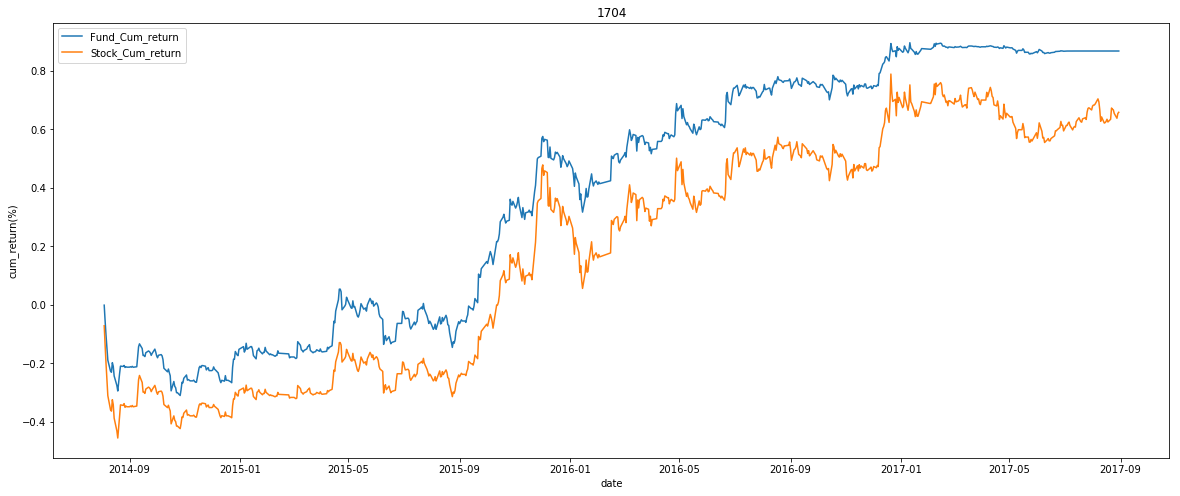

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()